# Downloading and Installing Dependencies

In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 4.2 MB/s eta 0:00:00


In [ ]:
import zipfile
import os
from PyPDF2 import PdfReader

# Function to extract text from a PDF file
def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text()
        return text

# Function to extract PDFs from zipfile, convert them to text, and save as .txt files
def extract_and_save_text_from_zip(zip_file_path, extract_to, output_zip_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

    # Create a new zip file to store the .txt files
    with zipfile.ZipFile(output_zip_path, 'w') as output_zip:
        for root, dirs, files in os.walk(extract_to):
            for file in files:
                if file.endswith(".pdf"):
                    pdf_path = os.path.join(root, file)
                    text = extract_text_from_pdf(pdf_path)

                    # Save the extracted text as a .txt file
                    text_filename = os.path.splitext(file)[0] + ".txt"
                    text_filepath = os.path.join(extract_to, text_filename)
                    with open(text_filepath, 'w', encoding='utf-8') as text_file:
                        text_file.write(text)

                    # Add the text file to the output zip
                    output_zip.write(text_filepath, arcname=text_filename)

# Example usage
zip_file_path = "Final_Resumes.zip"  # Path to your input zipfile containing PDFs
extract_to = "Final_Resumes_Text"  # Temporary directory to extract PDFs
output_zip_path = "extracted_text_files.zip"  # Path to the output zipfile with text files

# Extract text and create a zip of .txt files
extract_and_save_text_from_zip(zip_file_path, extract_to, output_zip_path)

print(f"Text files saved and zipped as {output_zip_path}")

Text files saved and zipped as extracted_text_files.zip


# Recommendation Parsing

In [ ]:
import chardet

def detect_encoding(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']

# Usage
file_encoding = detect_encoding('/content/Final_Recommendation_Letters/Recommendation_Letters_of_ID_0/Recommendation_From_ID_218.txt')
print(f"Detected Encoding: {file_encoding}")

Detected Encoding: Windows-1252


In [ ]:
import json

def sentiment_calculator(text_path):

    with open(text_path, 'r', encoding='Windows-1252') as f:
      text = f.read()

    # Initialize the Groq client
    client = Groq(
        api_key='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',
    )

    # Create the completion request with system and user messages
    completion = client.chat.completions.create(
        model="llama-3.1-70b-versatile",
        messages=[
            {
                "role": "system",
                "content": """
                You are provided a piece of text that contains various claims, both normal and exaggerated. Your task is to:
                  1. Identify all the claims in the text.
                  2. For normal claims, assign a sentiment score between 0 and 1.
                  3. For exaggerated claims, assign a sentiment score between 0 and 1.
                  4. Calculate the total sum of sentiment scores for normal claims and exaggerated claims separately.
                  5. Output the result as an integer, calculated using the formula:
                    (Average of normal sentiment scores) - 0.1 * (Average of exaggerated sentiment scores)

                  DO NOT Provide any intermediate steps in the response.

                  The final output should ONLY be the result of this formula.
                  """
            },
            {
                "role": "user",
                "content": f"""The text is provided below:\n {text}

                DO NOT Provide any intermediate steps in the response.

                The final output should ONLY be the result of the formula mentioned above.
                """
            }
        ],
        temperature=0.5,
        max_tokens=4096,
        top_p=1,
        stream=False,
        stop=None,
    )

    # Return the summary generated by the model
    return completion.choices[0].message.content

# Usage
summary = sentiment_calculator('/content/Final_Recommendation_Letters/Recommendation_Letters_of_ID_0/Recommendation_From_ID_218.txt')
print(summary)

0.55


# Exaggerated Claims

In [ ]:
def summarize_resume(client_id, project_id, structure, resume, i, model_type, api_key):
    """
    Summarizes a resume using a predefined JSON format.

    Parameters:
    - client_id: str, client identifier.
    - project_id: str, project identifier.
    - structure: dict, the desired JSON structure for the summary.
    - resume: str, the resume text to summarize.
    - i: int, the resume ID to include in the prompt.
    - model_type: str, the model to use (e.g., 'gpt-4').
    - api_key: str, the API key for authentication.

    Returns:
    - messages: list, updated conversation history.
    - response_content: str, the summarized resume in the desired format.
    """

    # Construct messages
    messages = [
        {
            "role": "system",
            "content": f'''Your task is to summarize a resume in the given JSON format:\n\n{structure}

            Instructions:
            1. Ensure that responsibilities is very concise and written down in bullet points. JUST mention the keywords of responsibilities.
            2. Make sure that skills are properly formatted (not uppercase completely or lowercase).
            '''
        },
        {
            "role": "user",
            "content": f"In the following prompt, you are given the resume of ID_{i}. Summarize it in the given format: {resume}"
        }
    ]

    # Call the chat_with_gpt function
    messages, response_content = chat_with_gpt(model_type, api_key, messages)

    return messages, response_content

# Skills Matching

In [ ]:
# prompt: read LOR_skills.csv

import pandas as pd

# Assuming 'LOR_skills.csv' is in your current working directory or you provide the correct path.
df_lor_skills = pd.read_csv('LOR_skills.csv')

In [ ]:
df_lor_skills.head()

,File,Skills
0,./Final_Recommendation_Letters\Recommendation_...,"['language art', 'student engagement', 'teachi..."
1,./Final_Recommendation_Letters\Recommendation_...,"['financial management', 'manage account', 'ac..."
2,./Final_Recommendation_Letters\Recommendation_...,"['financial management', 'account payable', 'p..."
3,./Final_Recommendation_Letters\Recommendation_...,"['customer service', 'financial system', 'fina..."
4,./Final_Recommendation_Letters\Recommendation_...,"['customer service', 'financial management', '..."


In [ ]:
import pandas as pd
import re

# Assuming you have the dataframe loaded as df
df = pd.read_csv('LOR_skills.csv')  # Replace with your actual file path

# Function to extract IDs using regex
def extract_ids(file_path):
    recommendee_id = re.search(r'Recommendation_Letters_of_ID_(\d+)', file_path).group(1)
    recommender_id = re.search(r'Recommendation_From_ID_(\d+)', file_path).group(1)
    return recommendee_id, recommender_id

# Apply the function to extract recommendee and recommender IDs
df[['Recommendee_ID', 'Recommender_ID']] = df['File'].apply(lambda x: pd.Series(extract_ids(x)))

# Display the updated dataframe
print(df)

                                                   File  \
0     ./Final_Recommendation_Letters\Recommendation_...   
1     ./Final_Recommendation_Letters\Recommendation_...   
2     ./Final_Recommendation_Letters\Recommendation_...   
3     ./Final_Recommendation_Letters\Recommendation_...   
4     ./Final_Recommendation_Letters\Recommendation_...   
...                                                 ...   
3080  ./Final_Recommendation_Letters\Recommendation_...   
3081  ./Final_Recommendation_Letters\Recommendation_...   
3082  ./Final_Recommendation_Letters\Recommendation_...   
3083  ./Final_Recommendation_Letters\Recommendation_...   
3084  ./Final_Recommendation_Letters\Recommendation_...   

                                                 Skills Recommendee_ID  \
0     ['language art', 'student engagement', 'teachi...              0   
1     ['financial management', 'manage account', 'ac...            103   
2     ['financial management', 'account payable', 'p...            10

In [ ]:
df = df.drop('File', axis=1)

In [ ]:
df.head()

,Skills,Recommendee_ID,Recommender_ID
0,"['language art', 'student engagement', 'teachi...",0,218
1,"['financial management', 'manage account', 'ac...",103,428
2,"['financial management', 'account payable', 'p...",103,857
3,"['customer service', 'financial system', 'fina...",107,15
4,"['customer service', 'financial management', '...",1,869


In [ ]:
df_sorted = df.sort_values('Recommendee_ID')

In [ ]:
df_sorted

,Skills,Recommendee_ID,Recommender_ID
0,"['language art', 'student engagement', 'teachi...",0,218
6,"['language art', 'language art', 'lesson plann...",0,391
26,"['critical thinking', 'project management', 'r...",1,412
19,"['project coordination', 'time management', 'r...",1,233
4,"['customer service', 'financial management', '...",1,869
...,...,...,...
3083,"['financial management', 'financial analysis',...",998,258
3084,"['financial regulation', 'customer satisfactio...",998,471
3081,"['information technology', 'information techno...",999,705
3077,"['network administration', 'information techno...",999,483


In [ ]:
import pandas as pd
import re
import json

# Load the JSON file (replace 'your_file.json' with the actual file path)
with open('/content/all_resumes_data.json') as f:
    data = json.load(f)

# Convert the JSON data into a pandas dataframe
df_resume = pd.DataFrame(data)

# Extract recommendee ID from the File_Name column using regex
df_resume['Recommendee_ID'] = df_resume['File_Name'].apply(lambda x: re.search(r'Resume_of_ID_(\d+)', x).group(1))

# Create a new dataframe with Skills and Recommendee_ID columns
df_resume = df_resume[['Skills', 'Recommendee_ID']]

In [ ]:
# prompt: Sort df_resume wrt recomendee_id

df_resume_sorted = df_resume.sort_values('Recommendee_ID')

In [ ]:
df_resume_sorted

,Skills,Recommendee_ID
616,"[arts, English, instruction, Latin, letters, L...",0
717,"[Adobe, Photoshop, streamline, Attorney, audio...",1
874,"[Adobe products, Photoshop, interpersonal and ...",10
4,"[Executive Level, Operations, Proposals,Â Coac...",100
613,"[Microsoft Office (Excel, Power Point, and Acc...",101
...,...,...
352,"[administrative, advertising, arts, budgeting,...",995
598,[Performance Evaluations],996
33,"[Active Directory, Azure,]",997
727,NaN,998


In [ ]:
# prompt: save df_resume_sorted and df_sorted

# Save df_resume_sorted to a CSV file
df_resume_sorted.to_csv('df_resume_sorted.csv', index=False)

# Save df_sorted to a CSV file
df_sorted.to_csv('df_sorted.csv', index=False)

# Final BERT Matching

In [ ]:
!pip install sentence_transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
df_resume_sorted

,Skills,Recommendee_ID
616,"[arts, English, instruction, Latin, letters, L...",0
717,"[Adobe, Photoshop, streamline, Attorney, audio...",1
874,"[Adobe products, Photoshop, interpersonal and ...",10
4,"[Executive Level, Operations, Proposals,Â Coac...",100
613,"[Microsoft Office (Excel, Power Point, and Acc...",101
...,...,...
352,"[administrative, advertising, arts, budgeting,...",995
598,[Performance Evaluations],996
33,"[Active Directory, Azure,]",997
727,NaN,998


In [ ]:
import pandas as pd
import torch
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics.pairwise import cosine_similarity

# Load RoBERTa model and tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

# Function to compute embeddings
def get_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the token embeddings to get a single vector
    return outputs.last_hidden_state.mean(dim=1).numpy()

# Assuming df_sorted and df_resume_sorted are already loaded
# df_sorted contains Recommendee_ID, Recommender_ID, and Skills
# df_resume_sorted contains Recommendee_ID and Skills

# Initialize a list to store the average similarity score for each Recommendee_ID
average_scores = []

# Iterate through each row in df_resume_sorted
for index, row in df_resume_sorted.iterrows():
    if pd.notna(row['Skills']) and isinstance(row['Skills'], list) and row['Skills']:
        resume_skills = row['Skills'][0]  # Assuming skills are in list format
    else:
        average_scores.append(0.0)  # Append 0 if no skills are available
        continue  # Skip to the next row

    # Get all the rows in df_sorted with the same Recommendee_ID
    recommendations = df_sorted[df_sorted['Recommendee_ID'] == row['Recommendee_ID']]

    # Initialize a list to store similarity scores for this Recommendee_ID
    similarity_scores = []

    for _, rec_row in recommendations.iterrows():
        rec_skills = rec_row['Skills'][0]

        # Get embeddings using RoBERTa
        embeddings1 = get_embeddings(resume_skills)
        embeddings2 = get_embeddings(rec_skills)

        # Compute cosine similarity
        similarity = cosine_similarity(embeddings1, embeddings2)[0][0]

        # Append the similarity score
        similarity_scores.append(similarity)

    # Compute the average similarity score
    if similarity_scores:
        average_score = sum(similarity_scores) / len(similarity_scores)
    else:
        average_score = 0.0

    # Append the average score to the list
    average_scores.append(average_score)

# Add the average similarity scores to df_resume_sorted as a new column
df_resume_sorted['Average_Skill_Similarity'] = average_scores

# Display the updated dataframe
print(df_resume_sorted)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-26-b9fade65927f>:27: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pd.notna(row['Skills']) and isinstance(row['Skills'], list) and row['Skills']:


                                                Skills Recommendee_ID  \
616  [arts, English, instruction, Latin, letters, L...              0   
717  [Adobe, Photoshop, streamline, Attorney, audio...              1   
874  [Adobe products, Photoshop, interpersonal and ...             10   
4    [Executive Level, Operations, Proposals,Â Coac...            100   
613  [Microsoft Office (Excel, Power Point, and Acc...            101   
..                                                 ...            ...   
352  [administrative, advertising, arts, budgeting,...            995   
598                          [Performance Evaluations]            996   
33                          [Active Directory, Azure,]            997   
727                                                NaN            998   
13   [IP networking protocols :TCP/IP,UDP,HTTP/S,DH...            999   

     Average_Skill_Similarity  
616                  0.853286  
717                  0.879560  
874                  0.8838

In [ ]:
df_resume_sorted.to_csv('df_resume_sorted.csv', index=False)

<Axes: xlabel='Average_Skill_Similarity', ylabel='Density'>

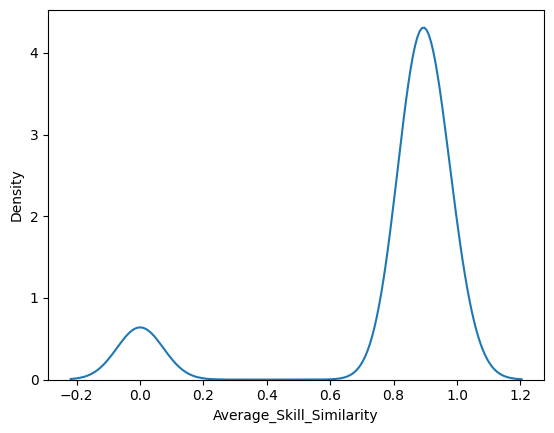

In [ ]:
import seaborn as sns

sns.kdeplot(df_resume_sorted['Average_Skill_Similarity'])